# memo 0628 
これをやってみる。  
https://dajiro.com/entry/2020/05/02/191334

参考記事（下はSARIMAXなので今回はやってない。　SARIMAXは季節性があるデータにたいして実施するやつ。ARIMAの季節性ありverっぽい？  
https://qiita.com/hcpmiyuki/items/b1783956dee20c6d4700  
https://www.lifull.blog/entry/2019/12/25/151030

* validでのaccuracyを計算　実装する　→　あってるか確認する
* 特徴量の作り方。どんな特徴量があるか？調べる　
* 時系列データでのCVのやり方　
* lightgbm のbinaryのmetric　違い

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
%matplotlib inline
import tqdm

from sklearn.model_selection import TimeSeriesSplit# 時系列データでCVをきる
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score# accuracy scoreを計算
import lightgbm as gbm

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


import scipy.stats as stats# 多数決あんさんぼー
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [42]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])


### 予測する対象のデータにflg = 1を建てる 

In [43]:
df_test['pred_flg'] = 0
df_test['pred_flg'][5::6] = 1 


<ipython-input-43-26de266eec36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_flg'][5::6] = 1


# ECA　0704を参照

##　トレンドを見る。
### 月の平均データを集計　可視化

In [44]:
df_train['month_close_mean'] = df_train['Date'].dt.strftime('%Y-%m')
df_train.groupby(['month_close_mean'],as_index = False).mean()

,month_close_mean,Open,High,Low,Close,Up
0,2004-01,51.045000,51.212000,50.854000,51.053500,0.600000
1,2004-02,52.412105,52.687895,52.312632,52.551579,0.473684
2,2004-03,53.680870,53.990870,53.502609,53.720870,0.565217
3,2004-04,53.086667,53.329048,52.842857,53.043810,0.428571
4,2004-05,51.883000,52.091500,51.668000,51.870000,0.500000
5,2004-06,52.242857,52.416667,52.107619,52.249524,0.428571
6,2004-07,52.502381,52.724762,52.370476,52.563333,0.476190
7,2004-08,52.238182,52.440000,52.074091,52.258182,0.363636
8,2004-09,52.848095,53.057143,52.710952,52.897619,0.523810
9,2004-10,53.569048,53.785238,53.405238,53.631429,0.476190


<AxesSubplot:xlabel='month_close_mean', ylabel='Close'>

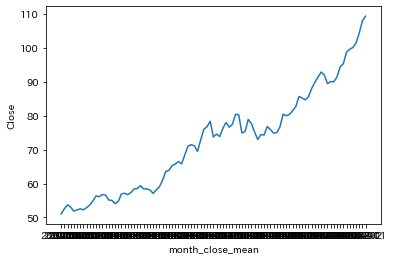

In [45]:
df_month_mean = df_train.groupby(['month_close_mean'],as_index = False).mean()
sns.lineplot(x = 'month_close_mean',y = 'Close',data = df_month_mean)

### 移動平均（トレンド）

In [46]:
df_train['mov_ave5'] = df_train['Close'].rolling(5).mean()
df_train['mov_ave10']= df_train['Close'].rolling(10).mean()
df_train['mov_ave20']= df_train['Close'].rolling(20).mean()

In [47]:
df_train.head(40)

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
5,2004-01-09,51.11,51.32,51.01,51.01,0,2004-01,51.148,NaN,NaN
6,2004-01-12,50.80,50.90,50.55,50.87,0,2004-01,51.164,NaN,NaN
7,2004-01-13,50.90,50.98,50.53,50.61,1,2004-01,51.056,NaN,NaN
8,2004-01-14,50.43,50.65,50.40,50.64,1,2004-01,50.882,NaN,NaN
9,2004-01-15,51.01,51.27,50.70,51.01,1,2004-01,50.828,50.959,NaN


No handles with labels found to put in legend.


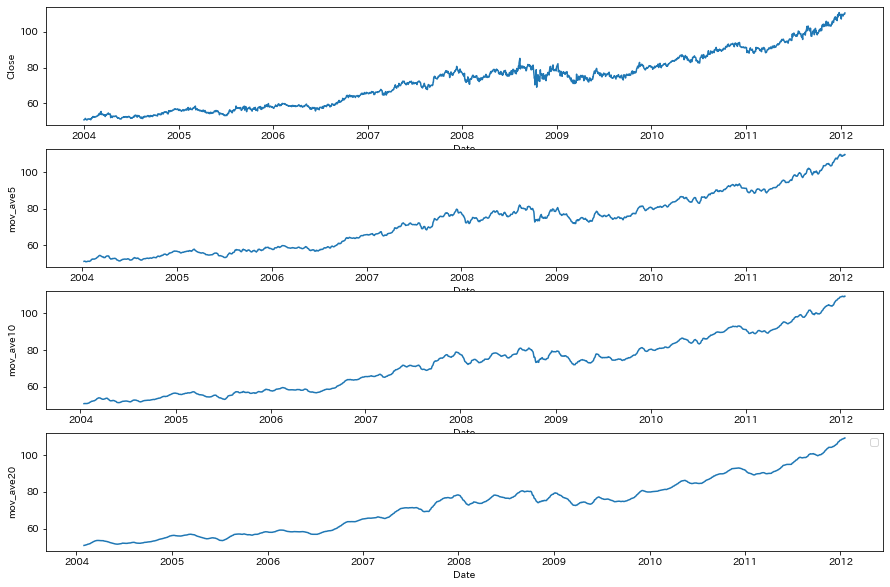

In [48]:
fig, axes = plt.subplots(nrows = 4,ncols = 1,figsize = (15,10))
sns.lineplot(data = df_train, x = 'Date', y = 'Close',ax=axes[0])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave5',ax=axes[1])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave10',ax=axes[2])
sns.lineplot(data = df_train, x = 'Date', y = 'mov_ave20',ax=axes[3])

plt.legend()
plt.show()

右肩上がり。　季節性はなさそう？？

### 自己相関、偏相関
自己相関：時系列データで時間軸ごとの各データの相関（昨日の俺と今日の俺と明日の俺・・・・  
編自己相関：tとt-2の相関にはt-1の情報が入っている可能性があるのでそれをさっ引いた相関　（今日の俺と一昨日の俺を比較したいが、今日の俺は昨日の俺からできてる）

#### 月の自己相関

ある時点のデータと時間をずらしたデータの相関をプロット

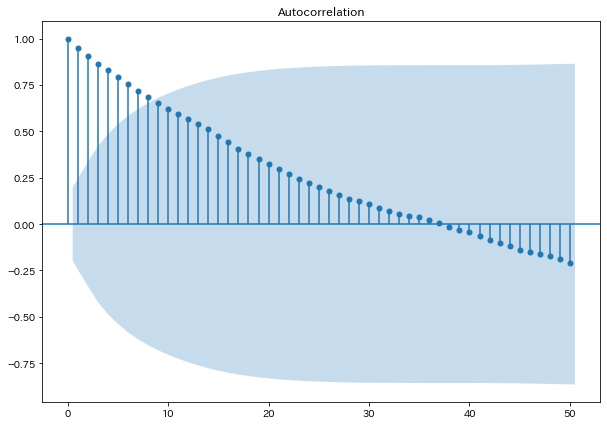

In [49]:
fig,axes = plt.subplots(1,1,figsize = (10,7))
sm.graphics.tsa.plot_acf(df_month_mean['Close'],lags = 50,ax = axes)
plt.show()

株価に周期性はなさそう

#### 月の偏自己相関を見てみる

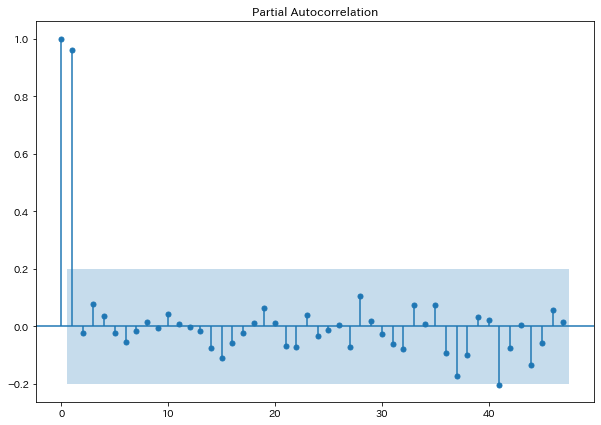

In [50]:
fig,axes = plt.subplots(1,1,figsize = (10,7))
sm.graphics.tsa.plot_pacf(df_month_mean['Close'],lags = 47,ax = axes)
plt.show()

#### ５日ごとの移動平均における偏自己相関
株価は上昇傾向なので自己相関は上と一緒  
偏自己相関だけみる

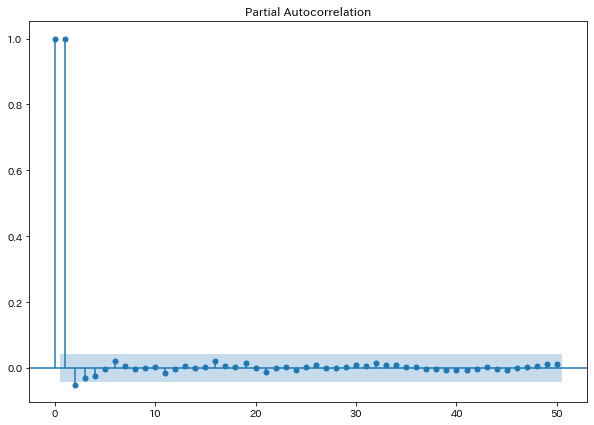

In [51]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave5'].dropna(),lags = 50,ax = axes)
plt.show()

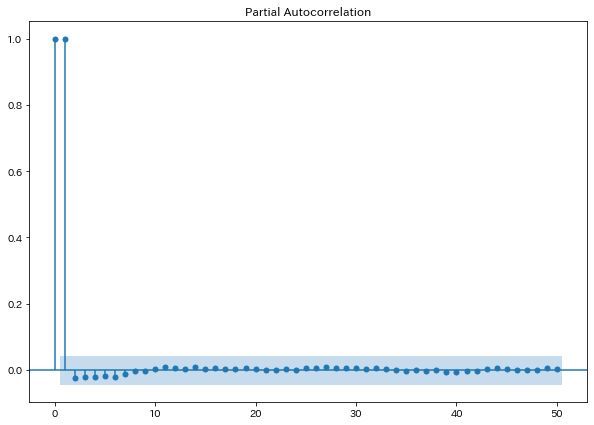

In [52]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave10'].dropna(),lags = 50,ax = axes)
plt.show()

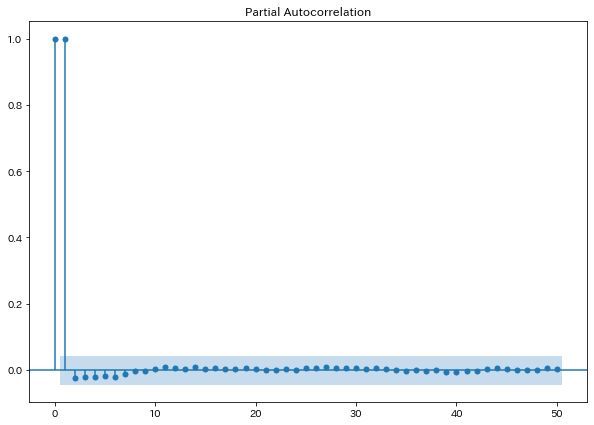

In [53]:
fig,axes = plt.subplots(1,1,figsize = (10,7))

sm.graphics.tsa.plot_pacf(df_train['mov_ave10'].dropna(),lags = 50,ax = axes)
plt.show()

月、５日移動平均、１０日移動平均、　いずれも前後では相関があるが、１個飛ばし以降のデータ（月なら翌々月）になると途端に相関はなくなる。

### トレンド　まとめ
1. 株価は全体的に上昇傾向があり、非定常である
2. 今月と翌月には相関があるが、翌々月には相関がない。  
   つまり、株価予測で重要なのは、一つ前の月の情報（先々月の情報はノイズになる）
1. 移動平均５日の場合でも同様。１個となりのデータは相関があるが、その次になると急に相関がなくなる。

## トレンド、季節性、残差に分解

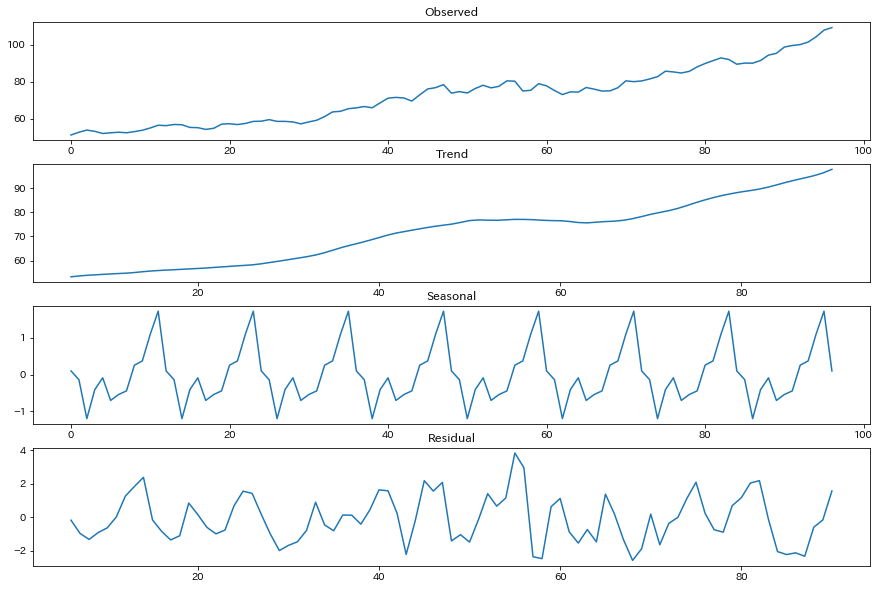

In [54]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_month_mean['Close'],period = 12)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(15,10))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

トレンドは上昇傾向  
季節性は実はある？が、縦軸の値が小さいのでほとんど効いてなさそう？　　

残差について：　　


ARIMAは定常であること、もしくは階差のデータが定常であることを前提にしたモデルなので、  
上記のdiffした結果定常であるならばARIMAが使えるということ

statsmodelsのseasonal_decomposeを使うと、トレンド、周期、残差に分割できる

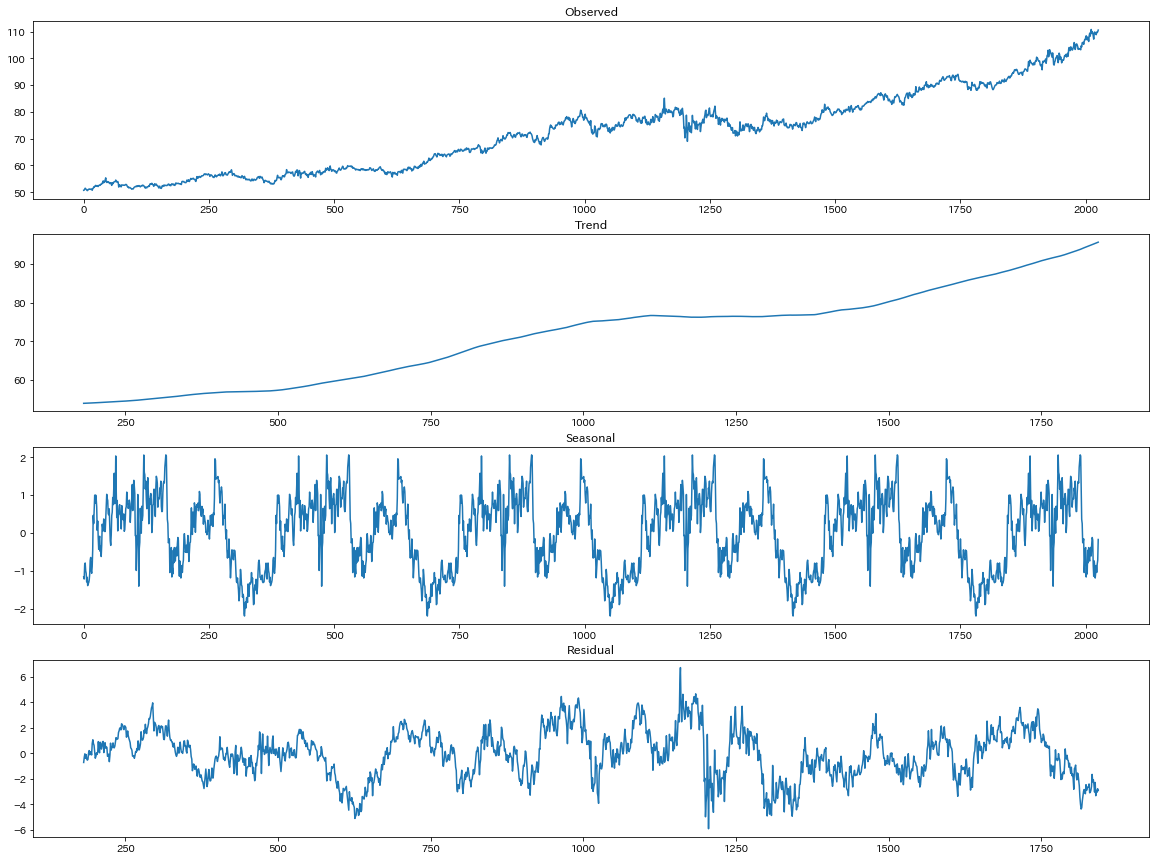

In [55]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_train['Close'],period = 365)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(20,15))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

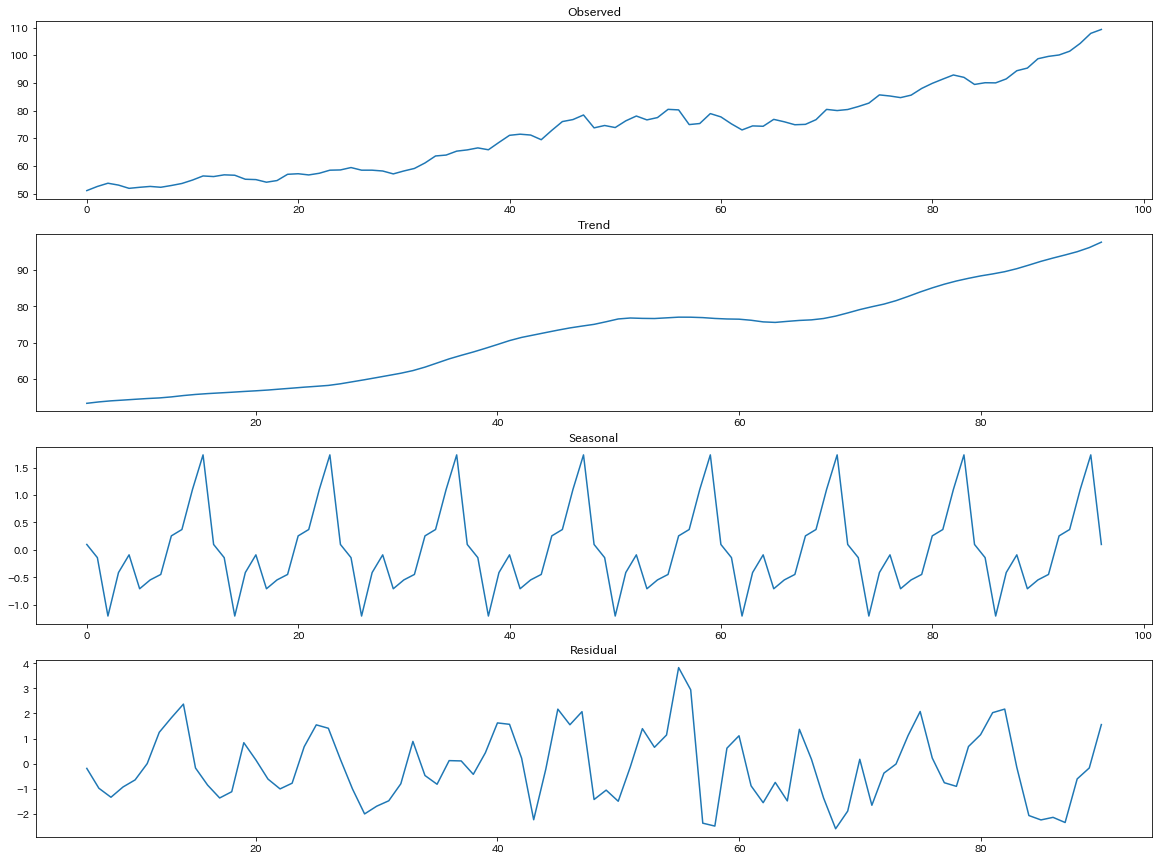

In [56]:
seasonal_decompose_res = sm.tsa.seasonal_decompose(df_month_mean['Close'],period = 12)

fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(20,15))

# 原系列
axes[0].set_title('Observed')
axes[0].plot(seasonal_decompose_res.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(seasonal_decompose_res.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(seasonal_decompose_res.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(seasonal_decompose_res.resid)

plt.show()

In [57]:
train_end = '2010-05-28'
val_start = '2010-06-09'
val_end = '2012-01-12'
test_start = '2012-01-19'
test_end = '2019-12-23'

In [58]:
df_train

,Date,Open,High,Low,Close,Up,month_close_mean,mov_ave5,mov_ave10,mov_ave20
0,2004-01-02,50.85,50.91,50.62,50.72,1,2004-01,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,2004-01,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,2004-01,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,51.51,0,2004-01,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,51.28,0,2004-01,51.090,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,2012-01,109.330,109.123,108.7065
2022,2012-01-12,109.68,109.90,109.44,109.83,0,2012-01,109.444,109.174,108.8065
2023,2012-01-13,109.53,109.72,109.08,109.66,1,2012-01,109.404,109.139,108.9445
2024,2012-01-17,109.99,110.47,109.57,109.96,1,2012-01,109.486,109.169,109.0460


In [59]:
feats = df_train.copy()

# 終値のみに絞る
feats= df_train[['Close']].copy()

# # 終わり値の1営業日リターン
# feats['return_1days'] = feats['Close'].pct_change(1)
# # 終わり値の2営業日リターン
# feats['return_2days'] = feats['Close'].pct_change(2)
# # 終わり値の3営業日リターン
# feats['return_3days'] = feats['Close'].pct_change(3)
# # 終わり値の4営業日リターン
# feats['return_4days'] = feats['Close'].pct_change(4)
# 終わり値の5営業日リターン
feats['return_5days'] = feats['Close'].pct_change(5)
# # 終わり値の6営業日リターン
# feats['return_6days'] = feats['Close'].pct_change(6)

# # 終値の1営業日ボラティリティ
# feats['volatility_1days'] = np.log(feats['Close']).diff().rolling(1).std()
# # 終値の2営業日ボラティリティ
# feats['volatility_2days'] = np.log(feats['Close']).diff().rolling(2).std()
# # 終値の3営業日ボラティリティ
# feats['volatility_3days'] = np.log(feats['Close']).diff().rolling(3).std()
# # 終値の4営業日ボラティリティ
# feats['volatility_4days'] = np.log(feats['Close']).diff().rolling(4).std()
# # 終値の5営業日ボラティリティ
feats['volatility_5days'] = np.log(feats['Close']).diff().rolling(5).std()


# # 終値の1営業日の単純移動平均線の剥離
# feats['MA_gap_1days'] = feats['Close'] / (feats['Close'].rolling(1).mean())
# # 終値の2営業日の単純移動平均線の剥離
# feats['MA_gap_2days'] = feats['Close'] / (feats['Close'].rolling(2).mean())
# # 終値の3営業日の単純移動平均線の剥離
# feats['MA_gap_3days'] = feats['Close'] / (feats['Close'].rolling(3).mean())
# # 終値の4営業日の単純移動平均線の剥離
# feats['MA_gap_4days'] = feats['Close'] / (feats['Close'].rolling(4).mean())
# 終値の5営業日の単純移動平均線の剥離
feats['MA_gap_5days'] = feats['Close'] / (feats['Close'].rolling(5).mean())


# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(['Close'],axis = 1)

feats.head(8)

,return_5days,volatility_5days,MA_gap_5days
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,1.003719
5,0.005718,0.005966,0.997302
6,0.001575,0.006205,0.994254
7,-0.010557,0.005205,0.991264


In [60]:
feats = pd.concat([df_train[['Date','Up','Close']],feats],axis = 1)
feats.head(20)

,Date,Up,Close,return_5days,volatility_5days,MA_gap_5days
0,2004-01-02,1,50.72,0.000000,0.000000,0.000000
1,2004-01-05,1,50.79,0.000000,0.000000,0.000000
2,2004-01-06,1,51.15,0.000000,0.000000,0.000000
3,2004-01-07,0,51.51,0.000000,0.000000,0.000000
4,2004-01-08,0,51.28,0.000000,0.000000,1.003719
5,2004-01-09,0,51.01,0.005718,0.005966,0.997302
6,2004-01-12,0,50.87,0.001575,0.006205,0.994254
7,2004-01-13,1,50.61,-0.010557,0.005205,0.991264
8,2004-01-14,1,50.64,-0.016890,0.002451,0.995244
9,2004-01-15,1,51.01,-0.005265,0.005231,1.003581


## 5-fold CVで学習
memo: $Accuracy = \frac{TP+TN}{TP+FP+TN+FN} = \frac{正解した行数の合計}{全データ（行数）合計}$

In [61]:
feats_X = feats.reset_index().loc[:,'return_5days':]
feats_y = feats.reset_index().loc[:,'Up']
date = feats.reset_index().loc[:,'Date']

In [64]:
feats_X

,return_5days,volatility_5days,MA_gap_5days
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,1.003719
...,...,...,...
2021,0.015580,0.009711,0.995701
2022,0.005217,0.005754,1.003527
2023,-0.001820,0.005234,1.002340
2024,0.003743,0.005170,1.004329


In [25]:
folds = TimeSeriesSplit(n_splits = 5)
    
# light gbm のパラメータ
params = {
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'max_depth' : 9,
        }

train_score =[]
valid_score =[]
models =[]
for i,(train_index, valid_index) in enumerate(folds.split(feats)):
    #　特徴量return_6days,volatility_5daysが未来の5日間の情報。リークしないように、test_indexは頭３個のindexは削除する
    valid_index = valid_index[5:]

    X_train, X_valid = feats_X.iloc[train_index],feats_X.iloc[valid_index]
    y_train, y_valid = feats_y[train_index], feats_y[valid_index]
    
    train_data = gbm.Dataset(X_train, y_train)
    valid_data = gbm.Dataset(X_valid, y_valid,reference = train_data)
    
    print('-----------------------------')
    print('model No:',i)
    model = gbm.train(params,
                    train_data,
                    valid_sets = [train_data,valid_data],
                    num_boost_round = 10000,
                    early_stopping_rounds = 10,
                    verbose_eval = 50
                    )

    
    # モデル評価
    # trainのモデル評価
    train_pred_prob = model.predict(X_train)# arrayで返ってくる。値は確率
    train_pred = np.where(train_pred_prob < 0.5 ,0,1 )# ０、１に変換
    train_pred_vs_data_df = pd.concat([y_train,pd.Series(train_pred,index = train_index)],axis = 1)# 真値と予測値のｄｆ作成
    train_pred_vs_data_df.columns = ['true','pred']
    
    # validのモデル評価
    valid_pred_prob = model.predict(X_valid)
    valid_pred = np.where(valid_pred_prob < 0.5 , 0 ,1)
    valid_pred_vs_data_df = pd.concat([y_valid,pd.Series(valid_pred, index = valid_index)],axis = 1)
    valid_pred_vs_data_df.columns = ['true','pred']
    
    train_score.append(accuracy_score(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred']))
    valid_score.append(accuracy_score(valid_pred_vs_data_df['true'],valid_pred_vs_data_df['pred']))
    
    models.append(model)
    


-----------------------------
model No: 0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 165, number of negative: 176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 341, number of used features: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483871 -> initscore=-0.064539
[LightGBM] [Info] Start training from score -0.064539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trai

In [26]:
train_score

[0.6715542521994134,
 0.6607669616519174,
 0.6857142857142857,
 0.6116863905325444,
 0.6080521018354056]

In [27]:
valid_score

[0.5150602409638554,
 0.5120481927710844,
 0.5451807228915663,
 0.5391566265060241,
 0.5301204819277109]

### 予測と真値を可視化して確認

In [ ]:
plt.plot()

In [ ]:
plt.plot(df_)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

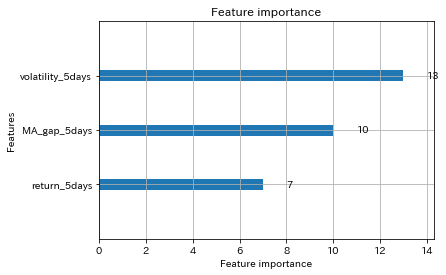

In [28]:
gbm.plot_importance(models[4])

# testデータで予測

In [29]:
feats_test = df_test.copy()

# 終値のみに絞る
feats_test= df_test[['Close']].copy()

# # 終わり値の1営業日リターン
# feats_test['return_1days'] = feats_test['Close'].pct_change(1)
# # 終わり値の1営業日リターン
# feats_test['return_2days'] = feats_test['Close'].pct_change(2)
# # 終わり値の1営業日リターン
# feats_test['return_3days'] = feats_test['Close'].pct_change(3)
# # 終わり値の1営業日リターン
# feats_test['return_4days'] = feats_test['Close'].pct_change(4)
# 終わり値の1営業日リターン
feats_test['return_5days'] = feats_test['Close'].pct_change(5)


# # 終値の1営業日ボラティリティ
# feats_test['volatility_1days'] = np.log(feats_test['Close']).diff().rolling(1).std()
# # 終値の2営業日ボラティリティ
# feats_test['volatility_2days'] = np.log(feats_test['Close']).diff().rolling(2).std()
# # 終値の3営業日ボラティリティ
# feats_test['volatility_3days'] = np.log(feats_test['Close']).diff().rolling(3).std()
# # 終値の4営業日ボラティリティ
# feats_test['volatility_4days'] = np.log(feats_test['Close']).diff().rolling(4).std()
# # 終値の5営業日ボラティリティ
feats_test['volatility_5days'] = np.log(feats_test['Close']).diff().rolling(5).std()


# # 終値の1営業日の単純移動平均線の剥離
# feats_test['MA_gap_1days'] = feats_test['Close'] / (feats_test['Close'].rolling(1).mean())
# # 終値の2営業日の単純移動平均線の剥離
# feats_test['MA_gap_2days'] = feats_test['Close'] / (feats_test['Close'].rolling(2).mean())
# # 終値の3営業日の単純移動平均線の剥離
# feats_test['MA_gap_3days'] = feats_test['Close'] / (feats_test['Close'].rolling(3).mean())
# # 終値の4営業日の単純移動平均線の剥離
# feats_test['MA_gap_4days'] = feats_test['Close'] / (feats_test['Close'].rolling(4).mean())
# # 終値の5営業日の単純移動平均線の剥離
feats_test['MA_gap_5days'] = feats_test['Close'] / (feats_test['Close'].rolling(5).mean())

# 欠損値処理
feats_test = feats_test.fillna(0)
# 元データのカラムを削除
feats_test = feats_test.drop(['Close'],axis = 1)

feats_test.head(8)

,return_5days,volatility_5days,MA_gap_5days
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.977486
5,-0.014856,0.014072,0.997487
6,-0.021945,0.013658,0.997807
7,-0.008699,0.015168,1.009728


In [30]:
# 一番最後に作ったモデルで予測
test_pred_prob = models[4].predict(feats_test)
test_pred = np.where(test_pred_prob < 0.5 , 0 ,1)
test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [40]:
test_pred_df = pd.concat([df_test[['Date','pred_flg']],pd.Series(test_pred)],axis = 1)

test_pred = test_pred_df.loc[test_pred_df['pred_flg']==1][['Date',0]]

In [41]:
test_pred_df

,Date,pred_flg,0
0,2012-01-19,0,1
1,2012-01-20,0,1
2,2012-01-23,0,1
3,2012-01-24,0,1
4,2012-01-25,0,1
...,...,...,...
1195,2019-12-17,0,1
1196,2019-12-18,0,0
1197,2019-12-19,0,1
1198,2019-12-20,0,1


In [42]:
test_pred

,Date,0
5,2012-01-26,1
11,2012-02-09,1
17,2012-02-24,1
23,2012-03-09,1
29,2012-03-23,1
...,...,...
1175,2019-10-25,1
1181,2019-11-08,0
1187,2019-11-22,1
1193,2019-12-09,1


In [ ]:
del test

In [43]:
test_pred.to_csv('submit.csv',index = False)